그림 그리기

In [1]:
from itertools import product
from typing import Optional

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import qiskit.providers.fake_provider as fp
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.primitives import Sampler
from qiskit.visualization import circuit_drawer, plot_gate_map
from qiskit_algorithms import EstimationProblem, AmplitudeEstimation

In [209]:
eval_qubit = 3
total_qubit = eval_qubit + 1

p = 0.3
theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
theta_for_q = 2 * theta_p  # Q의 각도

shots = 10000

In [210]:
qreg_q = QuantumRegister(total_qubit, 'q')
circuit = QuantumCircuit(qreg_q)

In [211]:
circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2 ** i), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()

circuit.append(QFT(eval_qubit, inverse=True, do_swaps=True),
               qreg_q[0:eval_qubit])
circuit.barrier()

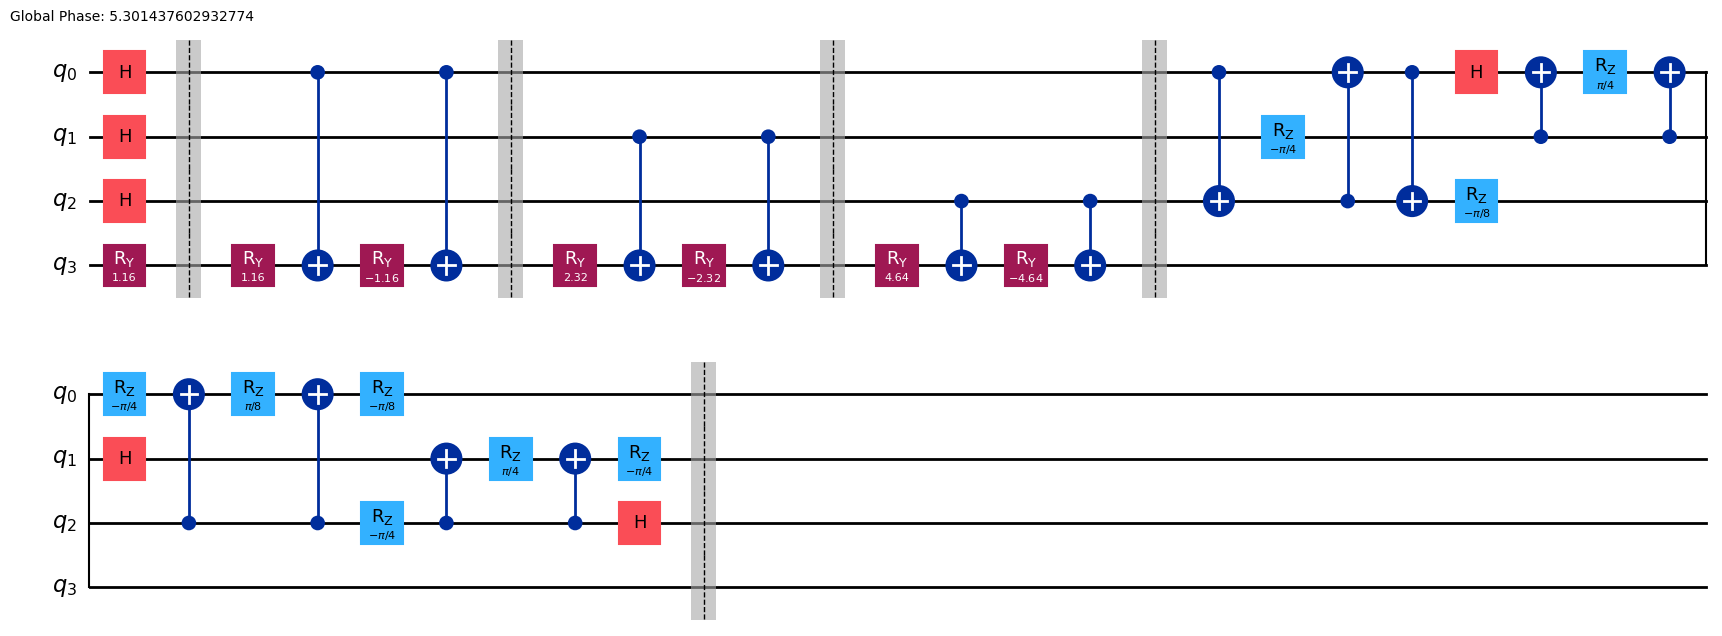

In [212]:
transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'ry']).draw(output='mpl', style="iqp")

Latex으로 vector 이미지 만들기 실패, 너무 긴데 조정이 안됨

In [213]:
# circuit.draw(output='latex_source', style="iqp", filename='test01.tex')

In [214]:
# transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'ry']).draw(output='latex_source', style="iqp", fold=10, filename='test02.tex')

# FIG 1

mpl에 global phase 값이 나와서 지워줘야 함

In [215]:
fig1_raw = transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'cry', 'ry'])

In [216]:
fig1_raw.__setattr__('_global_phase', 0)

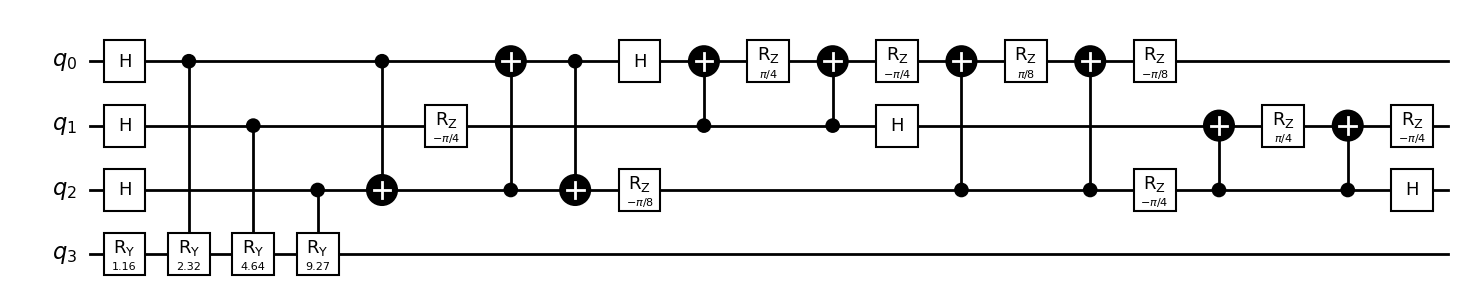

In [217]:
fig1_raw.draw(output='mpl', style="bw", fold=21, justify='left', filename='fig_1_raw.png', plot_barriers=False)

그림이 마음에 안들어서(depth 최적화) qasm으로 export 후 고친 후 다시 그리기

In [218]:
fig1_raw.qasm(formatted=True)
# hmm.qasm(formatted=True, filename='fig_1_raw.qasm')

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[0];
h q[1];
h q[2];
ry(1.1592794807274085) q[3];
barrier q[0],q[1],q[2],q[3];
cry(2.318558961454817) q[0],q[3];
barrier q[0],q[1],q[2],q[3];
cry(4.637117922909634) q[1],q[3];
barrier q[0],q[1],q[2],q[3];
cry(9.274235845819268) q[2],q[3];
barrier q[0],q[1],q[2],q[3];
cx q[0],q[2];
rz(-pi/4) q[1];
cx q[2],q[0];
cx q[0],q[2];
h q[0];
cx q[1],q[0];
rz(pi/4) q[0];
cx q[1],q[0];
rz(-pi/4) q[0];
h q[1];
rz(-pi/8) q[2];
cx q[2],q[0];
rz(pi/8) q[0];
cx q[2],q[0];
rz(-pi/8) q[0];
rz(-pi/4) q[2];
cx q[2],q[1];
rz(pi/4) q[1];
cx q[2],q[1];
rz(-pi/4) q[1];
h q[2];
barrier q[0],q[1],q[2],q[3];


In [219]:
fig1_raw_qasm = QuantumCircuit.from_qasm_file('fig_1_raw.qasm')

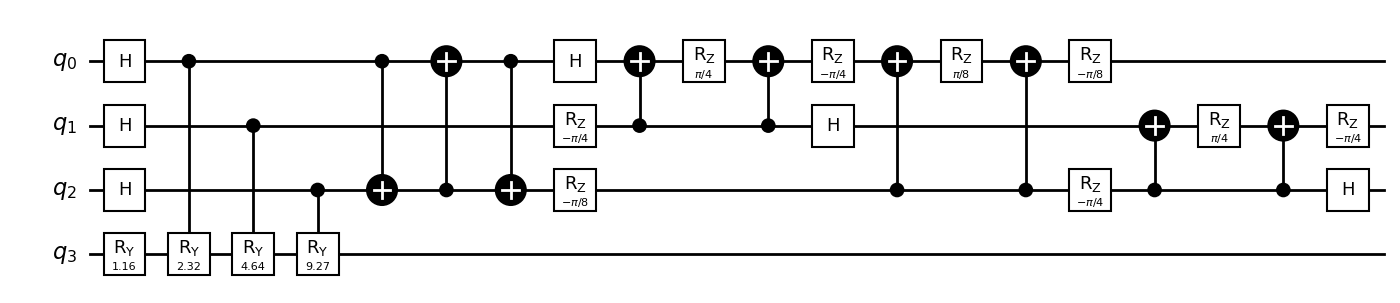

In [220]:
fig1_raw_qasm.draw(output='mpl', style="bw", fold=21, justify='left', filename='fig_1_raw.png', plot_barriers=False)

In [221]:
circuit = QuantumCircuit(qreg_q)

circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()

circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
               qreg_q[0:eval_qubit])
circuit.barrier()

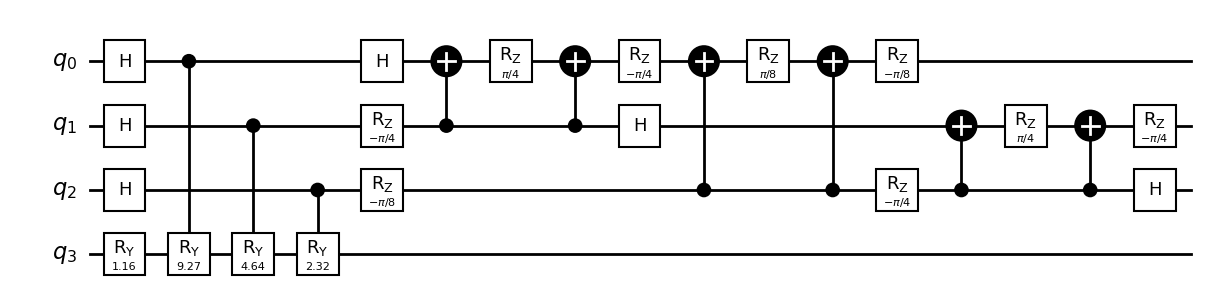

In [222]:
fig1_opt = transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'ry', 'cry'])
fig1_opt.__setattr__('_global_phase', 0)
fig1_opt.draw(output='mpl', style="bw", fold=18, filename='fig_1_opt.png', plot_barriers=False)

# FIG 2

In [226]:
class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        """
        # implement the efficient power of Q
        원래는 위의 #만 적혀있었음.
        이게 안쓰이나 싶었는데 쓰임.
        EstimationProblem instance 선언할 때 grover_operator arg를 받는데,
        grover_operator.power식으로 쓰이는듯?
        power function을 정의 안하면
        '각도를 2배로 하는 대신'
        '회로를 2번 돌려서 cx가 2배로 늘어남';;;;
        """
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [235]:
p = 0.3
A = BernoulliA(p)
Q = BernoulliQ(p)
problem = EstimationProblem(state_preparation=A,
                            grover_operator=Q,
                            objective_qubits=[0])
ae = AmplitudeEstimation(num_eval_qubits=3, sampler=Sampler())

In [236]:
backend = fp.FakeYorktown()

In [252]:
plot_gate_map(fp.FakeYorktown(), filename='fig_2_york.png')

In [253]:
plot_gate_map(fp.FakeTokyo(), filename='fig_2_tokyo.png')

# FIG 3

In [263]:
york_4 = transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend)

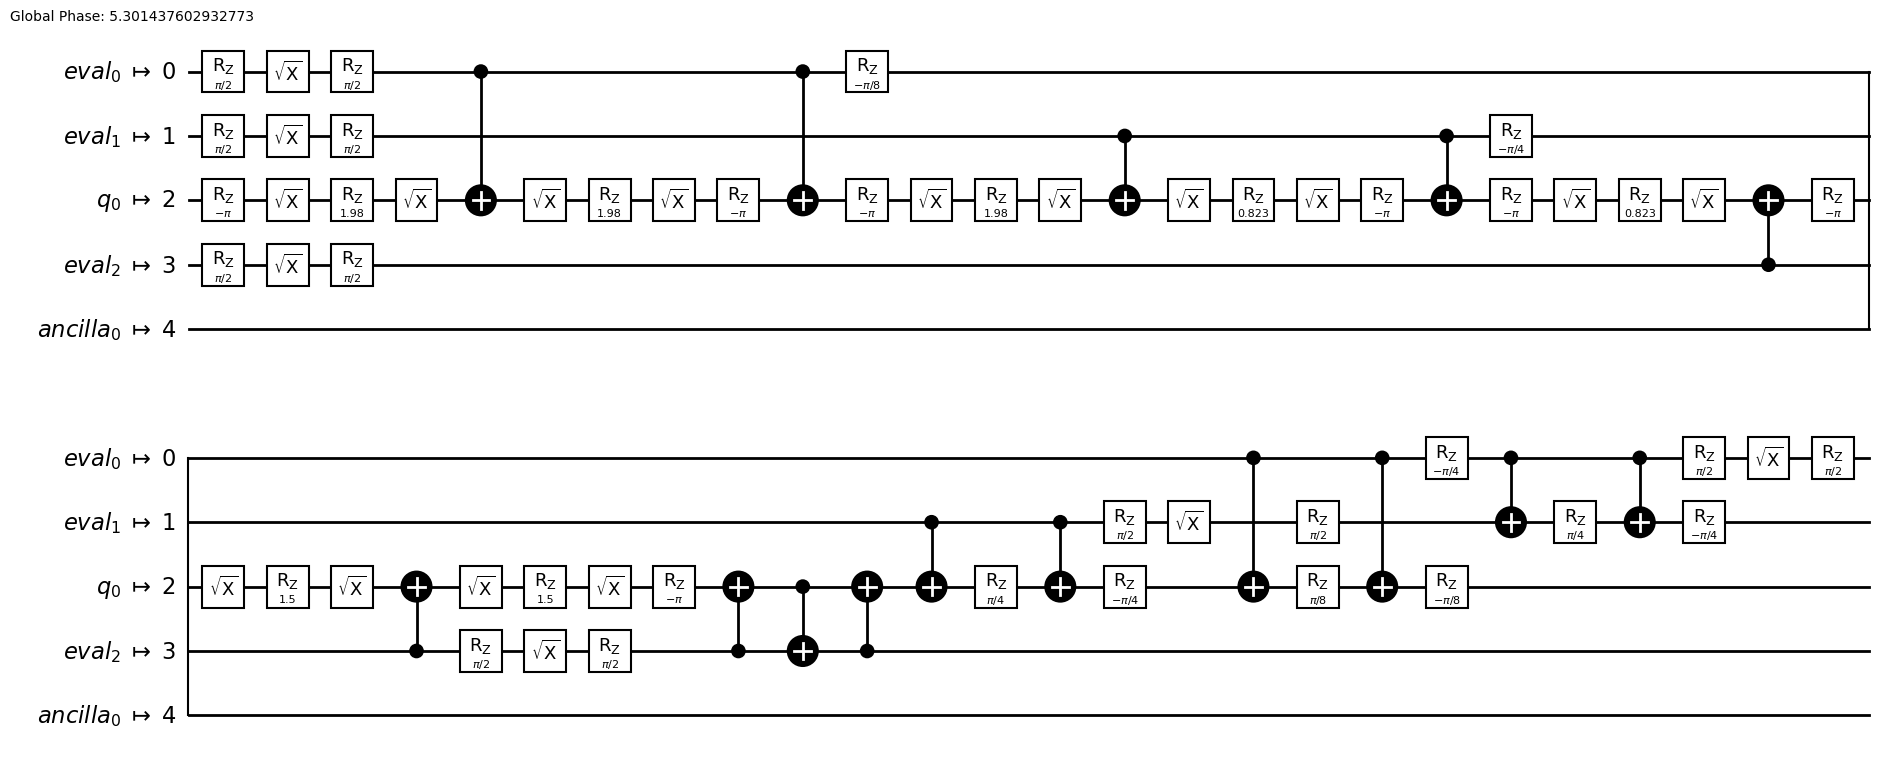

In [264]:
circuit_drawer(york_4, output='mpl', style="bw", fold=26)

In [265]:
# york_4.qasm(formatted=True, filename='fig_2_raw.qasm')
york_4.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
rz(pi/2) q[0];
sx q[0];
rz(pi/2) q[0];
rz(pi/2) q[1];
sx q[1];
rz(pi/2) q[1];
rz(-pi) q[2];
sx q[2];
rz(1.9823131728623853) q[2];
sx q[2];
cx q[0],q[2];
sx q[2];
rz(1.9823131728623844) q[2];
sx q[2];
rz(-pi) q[2];
cx q[0],q[2];
rz(-pi/8) q[0];
rz(-pi) q[2];
sx q[2];
rz(1.9823131728623853) q[2];
sx q[2];
cx q[1],q[2];
sx q[2];
rz(0.8230336921349761) q[2];
sx q[2];
rz(-pi) q[2];
cx q[1],q[2];
rz(-pi/4) q[1];
rz(-pi) q[2];
sx q[2];
rz(0.8230336921349761) q[2];
sx q[2];
rz(pi/2) q[3];
sx q[3];
rz(pi/2) q[3];
cx q[3],q[2];
rz(-pi) q[2];
sx q[2];
rz(1.4955252693198409) q[2];
sx q[2];
cx q[3],q[2];
sx q[2];
rz(1.4955252693198409) q[2];
sx q[2];
rz(-pi) q[2];
rz(pi/2) q[3];
sx q[3];
rz(pi/2) q[3];
cx q[3],q[2];
cx q[2],q[3];
cx q[3],q[2];
cx q[1],q[2];
rz(pi/4) q[2];
cx q[1],q[2];
rz(pi/2) q[1];
sx q[1];
rz(pi/2) q[1];
rz(-pi/4) q[2];
cx q[0],q[2];
rz(pi/8) q[2];
cx q[0],q[2];
rz(-pi/4) q[0];
cx q[0],q[1];
rz(pi/4) q[1];
cx q[0],q[1];
rz(pi/2) q[0

In [269]:
fig1_raw_qasm = QuantumCircuit.from_qasm_file('fig_2_raw.qasm')

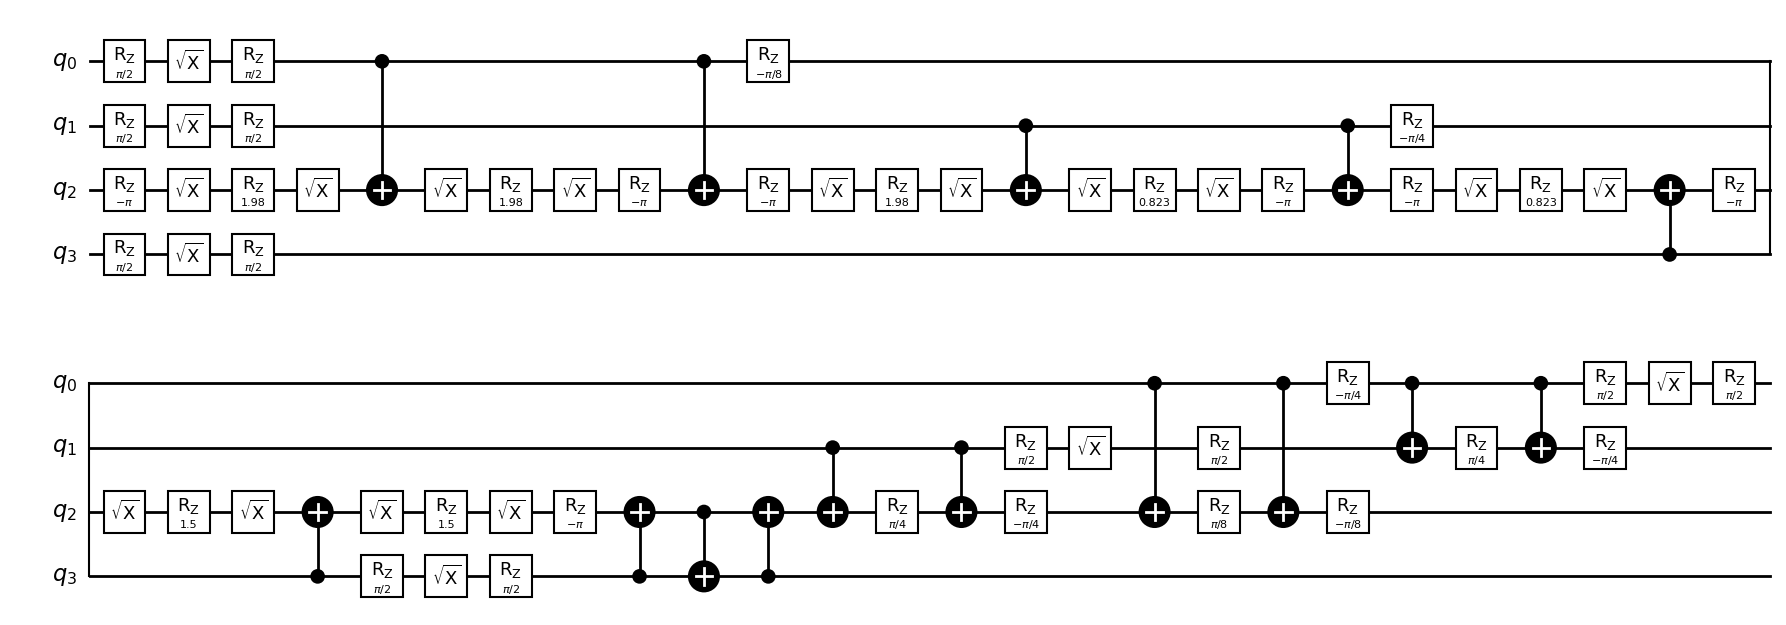

In [273]:
fig1_raw_qasm.draw(output='mpl', style="bw", fold=26, justify='left', filename='fig_2_york4.png', plot_barriers=False)

# FIG 4

In [2]:
def make_circuit(eval_qubit: int,
                 barrier: Optional[bool] = False,
                 measure: Optional[bool] = False) -> QuantumCircuit:
    eval_qubit = eval_qubit
    total_qubit = eval_qubit + 1  # eval + target qubit 1개

    p = 0.34
    theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
    theta_for_q = 2 * theta_p  # Q의 각도

    qreg_q = QuantumRegister(total_qubit, 'q')
    creg_c = ClassicalRegister(total_qubit - 1, 'c')  # 하나 없어도 되나?
    circuit = QuantumCircuit(qreg_q, creg_c)

    circuit.h(qreg_q[0:eval_qubit])
    circuit.ry(theta_p, qreg_q[eval_qubit])
    if barrier:
        circuit.barrier()

    for i in range(eval_qubit):
        circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
        if barrier:
            circuit.barrier()

    circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
                   qreg_q[0:eval_qubit])
    if barrier:
        circuit.barrier()
    if measure:
        for i in range(eval_qubit):
            circuit.measure(qreg_q[i], creg_c[i])

    return circuit

In [14]:
def transpile_circuit(circuit: QuantumCircuit, type: str) -> QuantumCircuit:
    if type == 'ionq':
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['rx', 'ry', 'rz', 'rxx', 'id'])
    if type == 'ibm_ideal':
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'])
    if type == 'ibm_yorktown':
        backend = fp.FakeYorktown()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1, 1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)
    if type == 'ibm_tokyo':
        backend = fp.FakeTokyo()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1, 1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)
    if type == 'ibm_guadalupe':
        backend = fp.FakeGuadalupe()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1, 1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)
    if type == 'ibm_washington':
        backend = fp.FakeWashington()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1, 1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)

    return transpiled_circuit

In [86]:
circuit_setting = {"eval_qubit": list(range(1, 16)),
                   "barrier": [False],
                   "measure": [False], }
transpile_setting = ['ionq', 'ibm_tokyo', 'ibm_guadalupe', 'ibm_washington']

In [123]:
result = pd.DataFrame(columns=['eval_qubit', 'barrier', 'measure', 'device', 'depth', 'two_qubit'])
for combo in product(*circuit_setting.values()):
    circuit = make_circuit(*combo)
    for type in transpile_setting:
        depth_list = []
        two_qubit_list = []
        for repetition in range(50):  ## adjust here to guarantee minima
            transpiled_circuit = transpile_circuit(circuit=circuit, type=type)

            depth_candidate = transpiled_circuit.depth()
            depth_list.append(depth_candidate)

            if type == 'ionq':
                two_qubit_candidate = transpiled_circuit.count_ops()['rxx']
                two_qubit_list.append(two_qubit_candidate)
            else:
                two_qubit_candidate = transpiled_circuit.count_ops()['cx']
                two_qubit_list.append(two_qubit_candidate)
        depth = min(depth_list)
        two_qubit = min(two_qubit_list)
        result.loc[len(result)] = [*combo, type, depth, two_qubit]

In [124]:
fig = px.line(result, x='eval_qubit', y='two_qubit', color='device', symbol='device',
              labels={'two_qubit': 'Entangling Gate',
                      'eval_qubit': 'Sampling Qubit'},
              template='plotly_white',
              )

In [125]:
# Remove grid lines
# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)

# dash_styles = ["solid", "dot", "dash", "dashdot", "longdashdot"]
# devices = result['device'].unique()  # Get unique devices

# Update traces with different dash styles
# for i, device in enumerate(devices):
#     fig.update_traces(selector=dict(name=device), line=dict(dash=dash_styles[i % len(dash_styles)]))
#     
# fig.update_traces(line=dict(color='black'))


fig.update_layout(
    font_family="Times New Roman",  # Or any other font that suits your thesis
    font_size=20,
    font_color="black",
    title_font_family="Times New Roman",  # Consistency in font usage
    title_font_size=16,
    legend_title_font_color="black"  # Customize legend title color if needed
)

In [126]:
fig.write_image("fig4_2qubit.png", scale=5)

In [127]:
fig2 = px.line(result, x='eval_qubit', y='depth', color='device', symbol='device',
              labels={'depth': 'Depth',
                      'eval_qubit': 'Sampling Qubit'},
              template='plotly_white',
              )
fig2.update_layout(
    font_family="Times New Roman",  # Or any other font that suits your thesis
    font_size=20,
    font_color="black",
    title_font_family="Times New Roman",  # Consistency in font usage
    title_font_size=16,
    legend_title_font_color="black"  # Customize legend title color if needed
)

In [128]:
fig2.write_image("fig4_depth.png", scale=5)

# 흠... 안쓸듯

In [64]:
result

,eval_qubit,barrier,measure,device,depth,two_qubit
0,2,False,False,ionq,18,6
1,2,False,False,ibm_ideal,27,6
2,2,False,False,ibm_yorktown,27,6
3,2,False,False,ibm_tokyo,27,6
4,2,False,False,ibm_guadalupe,27,9
5,2,False,False,ibm_washington,27,9
6,3,False,False,ionq,29,12
7,3,False,False,ibm_ideal,41,12
8,3,False,False,ibm_yorktown,47,15
9,3,False,False,ibm_tokyo,41,12


In [48]:
result_pivot = result.pivot(index='eval_qubit', columns='device', values='two_qubit').reset_index()

In [49]:
result_pivot

device,eval_qubit,ibm_washington,ionq
0,2,7,6
1,3,18,12
2,4,30,20
3,5,50,30
4,6,76,42
5,7,109,56
6,8,143,72
7,9,185,90
8,10,231,110
9,11,286,132


In [50]:
def linear(x, a, b):
    return a * x + b


def polynomial(x, a, b, c):
    return a * x ** 2 + b * x + c


def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

In [51]:
# 데이터 피팅 ibm_washington
params_linear, _ = curve_fit(linear, result_pivot['eval_qubit'], result_pivot['ibm_washington'])
params_poly, _ = curve_fit(polynomial, result_pivot['eval_qubit'], result_pivot['ibm_washington'])
# params_exp, _ = curve_fit(exponential, result_pivot['eval_qubit'], result_pivot['ionq'], maxfev=5000)

# 피팅 결과 시각화
x_range = np.linspace(min(result_pivot['eval_qubit']), max(result_pivot['eval_qubit']), 400)


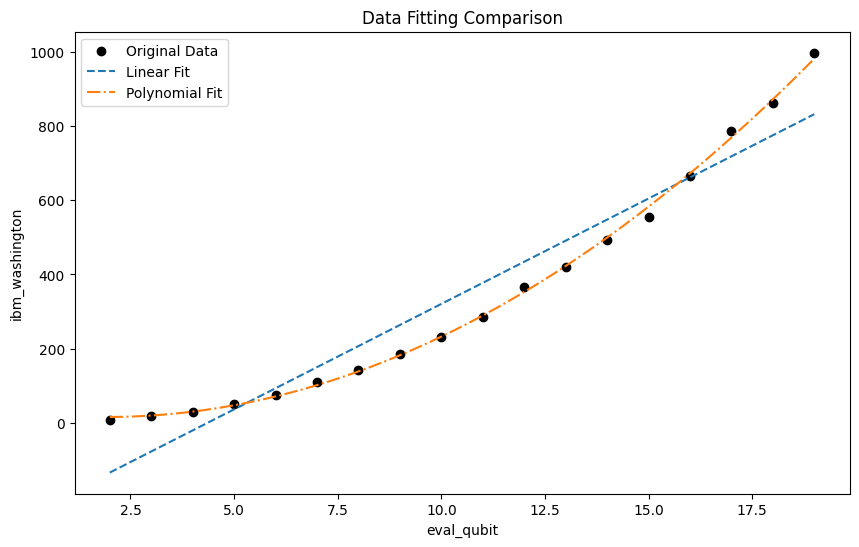

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(result_pivot['eval_qubit'], result_pivot['ibm_washington'], label='Original Data', color='black')
plt.plot(x_range, linear(x_range, *params_linear), label='Linear Fit', linestyle='--')
plt.plot(x_range, polynomial(x_range, *params_poly), label='Polynomial Fit', linestyle='-.')
# plt.plot(x_range, exponential(x_range, *params_exp), label='Exponential Fit', linestyle=':')
plt.legend()
plt.xlabel('eval_qubit')
plt.ylabel('ibm_washington')
plt.title('Data Fitting Comparison')
plt.show()

In [53]:
params_poly

array([  3.30450205, -12.56482162,  27.55198507])